Determining Equivalance Relative Spectral Response

In [13]:
%matplotlib inline
from matplotlib import pyplot as pl
import numpy as np
import math
from scipy.interpolate import UnivariateSpline
import scipy.optimize as opt
from scipy.optimize import fsolve
from scipy import signal
from scipy import ndimage
#import mpld3

#mpld3.enable_notebook()

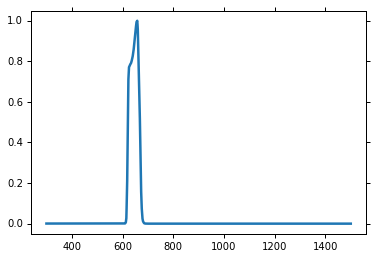

In [14]:
# Created structured array with names
s2amsi = np.genfromtxt('S2AMSI.rsr', dtype=float, delimiter=',', names=True) 
ls8oli = np.genfromtxt('LS8OLI.rsr', dtype=float, delimiter=',', names=True)
terra_modis = np.genfromtxt('MODIS_FM1_IB_OOB_RSR_merged.csv', dtype=float, delimiter=',', names=True)

# reshape and interpolate to enable comparison 
def reshape_interpolate(start, stop, samples, npdatatype, input1dwavelength,input1drsr,wlscalefactor):
    wavelength = np.linspace(start,stop,samples, dtype=float)
    rsr = np.nan_to_num(np.interp(wavelength,input1dwavelength*wlscalefactor, input1drsr))
    return wavelength, rsr

wl, response = reshape_interpolate(300,1500,12000,'float', terra_modis['Band_1'] , terra_modis['Band_1RSR'], 1000 )

#print terra_modis.dtype.names

pl.plot(wl,response)
pl.show()


In [15]:
# Single band example
wavelength = s2amsi['SR_WL']
target_band = s2amsi['Band_2']

In [16]:
# FWHM calculation
def make_norm_dist(x, mean, sd):
    return 1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x - mean)**2/(2*sd**2))

# create a spline of wavelength and blue-np.max(blue)/2 
spline = UnivariateSpline(wavelength, target_band-target_band.max()/2, s=0)

# find the roots
r1, r2 = spline.roots()

In [17]:
# FWHM calculation
fwhm = 2*np.sqrt(2*(math.log(2)))*target_band.std()

print "FWHM",fwhm

FWHM 0.267053394554


[ 469.75019391  469.75019391  469.75019391 ...,  469.75019391  469.75019391
  469.75019391] [ 523.91036181  523.91036181  523.91036181 ...,  523.91036181  523.91036181
  523.91036181]


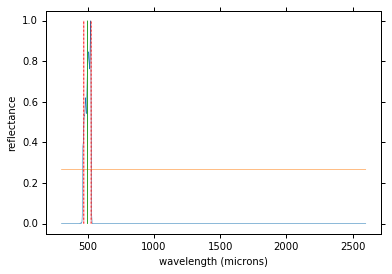

In [26]:
shapex = np.shape(wavelength)
shapey = np.shape(target_band)

# Power weighted mean wavelength
mean_wavelength = np.average(wavelength, weights=target_band)

# axhline, axvline don't play nicely with mpld3 - make arrays instead
fwhm_array = np.full(shapex,fwhm, dtype=np.float)
mean_wavelength_array = np.full(shapey, mean_wavelength, dtype=np.float)


r1_array = np.full(shapey, r1, dtype=np.float)
r2_array = np.full(shapey, r2, dtype=np.float)

pl.plot(wavelength,target_band,linewidth=0.5)
pl.plot(wavelength, fwhm_array,linewidth=0.5)
pl.plot(mean_wavelength_array, target_band,linewidth=0.5)
pl.plot(r1_array, target_band, 'r--',linewidth=0.5)
pl.plot(r2_array, target_band, 'r--',linewidth=0.5)
pl.xlabel('wavelength (microns)')
pl.ylabel('reflectance')
pl.show()

0.94157488367


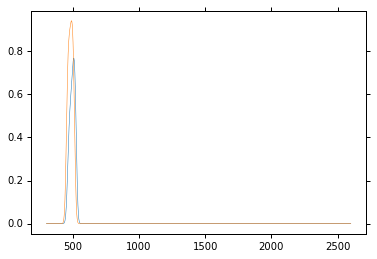

4.68758869171


In [21]:
#Earth Mover Distance example
# From - https://github.com/andreasjansson/python-emd

import emd

oli_blue = ndimage.filters.gaussian_filter(ls8oli['blue'], 10)
s2a_blue = ndimage.filters.gaussian_filter(s2amsi['Band_2'], 10)
print oli_blue.max()

pl.plot(wavelength, s2a_blue, linewidth=0.5)
pl.plot(wavelength, oli_blue, linewidth=0.5)
pl.show()
print emd.emd(range(500), range(500), signal.resample(oli_blue,500), signal.resample(s2a_blue,500))

In [32]:
def plotcomparison(x,y,colour):
    spline = UnivariateSpline(x, y-y.max()/2, s=0)
    # find the roots
    r1, r2 = spline.roots()
    fwhm = 2*np.sqrt(2*(math.log(2)))*y.std()
    shapex = np.shape(x)
    shapey = np.shape(y)

    # Power weighted mean wavelength
    mean_wavelength = np.average(x, weights=y)
    fwhm_array = np.full(shapex,fwhm, dtype=np.float)
    mean_wavelength_array = np.full(shapey, mean_wavelength, dtype=np.float)
    
    r1_array = np.full(shapey, r1, dtype=np.float)
    r2_array = np.full(shapey, r2, dtype=np.float)
    

    pl.plot(x,y, linewidth=1)
    pl.plot(x, fwhm_array, linewidth=1)
    pl.plot(mean_wavelength_array, y, colour, linewidth=1)
    pl.plot(r1_array, y, 'r--', linewidth=1)
    pl.plot(r2_array, y, 'r--', linewidth=1)

    pl.xlabel('wavelength (microns)')
    pl.ylabel('reflectance')

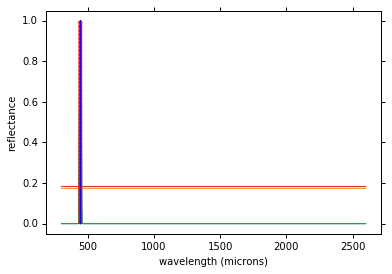

correlate: [ 12.73287304] EMD: 0.147929012775 trapz: Band_1 16.177387414 coastal 15.907091


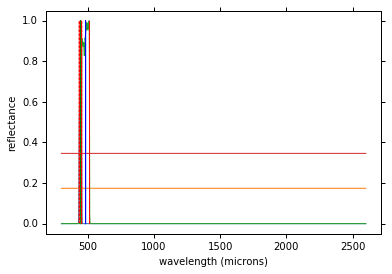

correlate: [ 1.31207688] EMD: 3.05780673027 trapz: Band_1 16.177387414 blue 56.283809


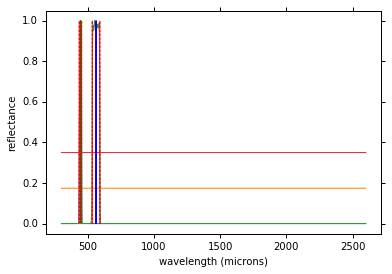

correlate: [ 0.] EMD: 20.3992328644 trapz: Band_1 16.177387414 green 56.11203


KeyboardInterrupt: 

In [33]:
sensor1 = s2amsi
sensor2 = ls8oli
for i in sensor1.dtype.names:
    for j in sensor2.dtype.names:
        if (i == 'SR_WL') or (j == 'SR_WL'):
            print
        else:
            #print i, j
            plotcomparison(wavelength,sensor1[i],'g')
            plotcomparison(wavelength,sensor2[j],'b')
            pl.show()
            
            # Earth Mover Distance
            A = ndimage.filters.gaussian_filter(sensor1[i], 10)
            B = ndimage.filters.gaussian_filter(sensor2[j], 10)

            EMD = emd.emd(range(500), range(500), signal.resample(A,500), signal.resample(B,500))
            
            print "correlate:", np.correlate(sensor1[i],sensor2[j]), "EMD:", EMD, "trapz:", i, np.trapz(sensor1[i], wavelength),  j, np.trapz(sensor2[j], wavelength) 
